# Functions and Function Spaces

Operator learning is motivated by the fact that many problems in science and
engineering are formulated in terms of functions.
While conventional neural networks learn between vector-spaces, neural operators
learn mappings between infinite-dimensional function spaces.

This notebook gives an introduction into functions, function spaces (or function sets),
and how these concepts are implemented in Continuity.


In [118]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [119]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch

torch.manual_seed(0)
plt.rcParams["axes.facecolor"] = (1, 1, 1, 0)
plt.rcParams["figure.facecolor"] = (1, 1, 1, 0)
plt.rcParams["legend.framealpha"] = 0.0

## Functions

A function is a mapping between a set $X$ (domain) and a set $Y$ (co-domain),
denoted by

\begin{align*}
f: X &\rightarrow Y, \\
x &\mapsto f(x).
\end{align*}


For example, the function $f(x)=x^2$ maps each element $x\in X = [-1,1] \subset \mathbb{R}$ to an element of $Y = [0,1] \subset \mathbb{R}$.

In Continuity, functions are handled by a `Function` object that takes a callable as input.
As an example, we define two functions $f$ and $g$: 

$$
f(x) = \sin(\pi x), \qquad g(x) = x^3, \qquad x\in \mathbb{R}.
$$

In [120]:
from continuity.data.function_dataset import Function

f = Function(lambda x: torch.sin(torch.pi * x))
g = Function(lambda x: x ** 3)

Functions are evaluated by calling them.

In [121]:
x = torch.linspace(-1, 1, 100)
y = f(x)
z = g(x)

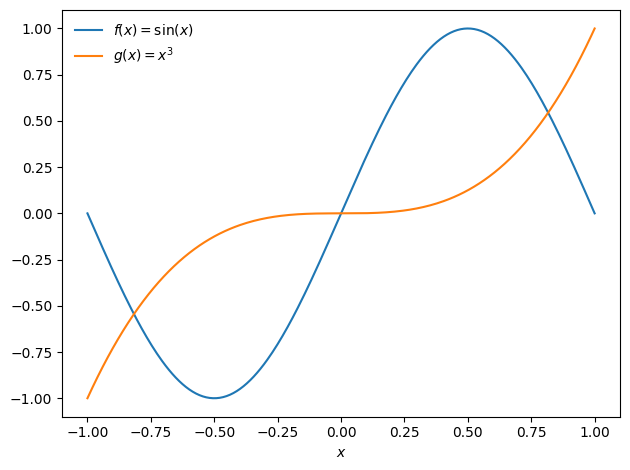

In [122]:
x_plot = torch.linspace(-1, 1, 300)
plt.plot(x_plot, f(x_plot), label="$f(x)=\sin(x)$")
plt.plot(x_plot, g(x_plot), label="$g(x)=x^3$")
plt.xlabel("$x$")
plt.legend()
plt.tight_layout()

Functions can be added to, subtracted from, multiplied with, and divided by other functions.
For instance:

In [123]:
h_1 = f + g
h_2 = (-1) * (f + g)

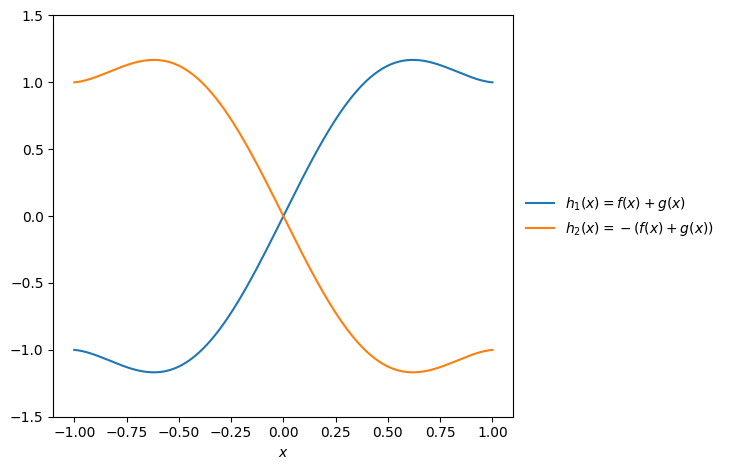

In [124]:
fig, ax = plt.subplots()
ax.plot(x_plot, h_1(x_plot), label="$h_1(x)=f(x)+g(x)$")
ax.plot(x_plot, h_2(x_plot), label="$h_2(x)=-(f(x)+ g(x))$")
ax.set_ylim(-1.5, 1.5)
ax.set_xlabel("$x$")
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()

## Function Sets

 For a domain $X$ supported on a field $K_1$, and the codomain $Y$ supported on a field $K_2$ a function space is the set of functions $F(X, Y)$ that map from $X$ to $Y$. The set $F(X,Y)$ becomes a vector space if the addition $(f+g)(x):X \rightarrow Y, x\mapsto f(x)+g(x)$ and scalar multiplication $(c\cdot f)(x) \rightarrow Y, x\mapsto c\cdot f(x)$ are supported for all functions in this set. 

In Continuity we deal with discrete representations of function spaces. As the two properties above can not always be respected (especially in the context of discrete representations of functions) we call these sets function sets.
Here we define a sine wave model
$$
y = \beta \cdot \sin(k x +\varphi ),\quad A=[\beta, k, \varphi]^\top\in\mathbb{R}^3,\quad x, y\in\mathbb{R}.
$$
For this set the property of scalar multiplication holds, but addition fails. Thus, this set of functions is not a function space. In Continuity function sets are handled by a `FunctionSet` and takes a nested callable as input.
When `FunctionSet` is called with a set of parameters it returns a list of `Function` instances.

In [125]:
from continuity.data.function_dataset import FunctionSet

sine_set = FunctionSet(lambda a: lambda x: a[0] * torch.sin(a[1] * x + a[2]))

parameters = 5 * torch.rand(4, 3)  # 4 sets of 3 parameters

sines = sine_set(parameters)

print(f"A set of {parameters.size(0)} parameters results in {len(sines)} sine functions.")

A set of 4 parameters results in 4 sine functions.


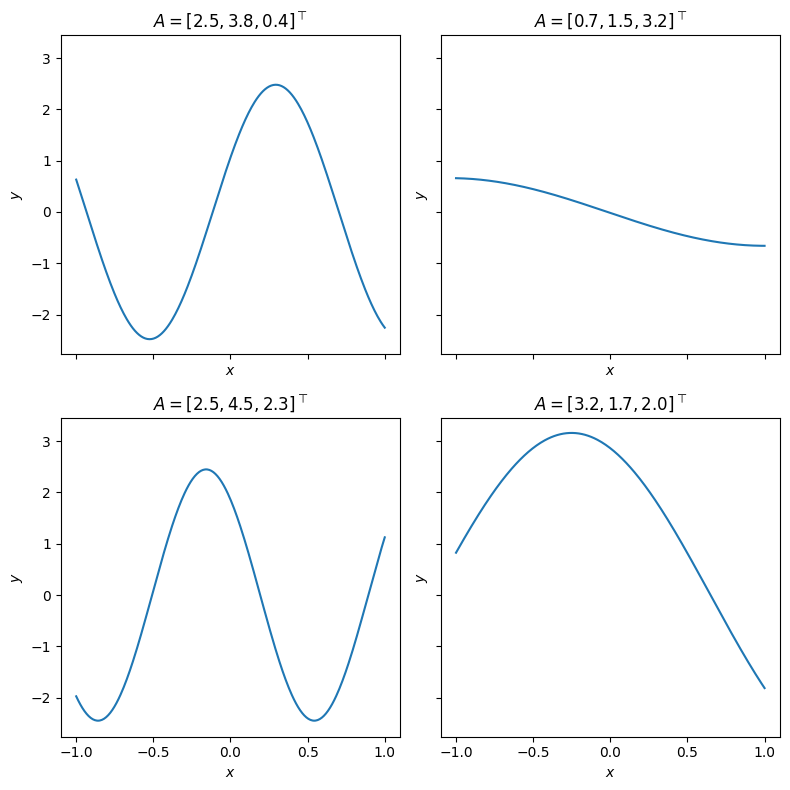

In [126]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

for i, (pi, sine) in enumerate(zip(parameters, sines)):
    row, col = i // 2, i % 2
    param = [f'{nbr: .1f}' for nbr in pi.tolist()]
    axs[row, col].plot(x_plot, sine(x_plot))
    axs[row, col].title.set_text(rf"$A=[{','.join(param)}]^\top$")
    axs[row, col].set_xlabel("$x$")
    axs[row, col].set_ylabel("$y$")
fig.tight_layout()

## Sampler

In Continuity there are samplers to create discrete representations of continuous functions. The following example shows how the `RegularGridSampler` and the `UniformBoxSampler` handle this. Both take two corner points of a $n$-dimensional rectangle as inputs.

Note: These two samplers are children of the `BoxSampler` class. More general sampler implementations will be implemented in the future. 

In [127]:
from continuity.discrete import RegularGridSampler, UniformBoxSampler

sampler_a = RegularGridSampler(torch.tensor([1., 1.]), torch.tensor([1.5, 2.5]))
sampler_b = UniformBoxSampler(torch.tensor([1., -.5]), torch.tensor([2., .5]))

# draw samples
n_samples = 102
samples_a = sampler_a(n_samples)
samples_b = sampler_b(n_samples)

print(f"Shape of sample A: {samples_a.shape}, Shape of sample B: {samples_b.shape}")

Shape of sample A: torch.Size([102, 2]), Shape of sample B: torch.Size([102, 2])


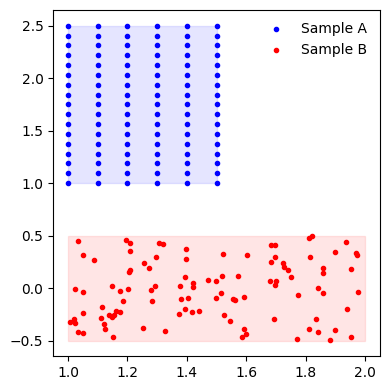

In [128]:
fig, ax = plt.subplots(figsize=(4, 4))
ax.plot(samples_a[:, 0], samples_a[:, 1], 'b.', label="Sample A")
a_bbox = patches.Rectangle((1, 1), .5, 1.5, alpha=0.1, color='b')
ax.add_patch(a_bbox)
ax.plot(samples_b[:, 0], samples_b[:, 1], 'r.', label="Sample B")
b_bbox = patches.Rectangle((1, -.5), 1, 1, alpha=0.1, color='r')
ax.add_patch(b_bbox)
ax.legend()
fig.tight_layout()

## Function Operator Datasets

In Continuity the concepts of function sets and samplers are combined to form `FunctionOperatorDataset` instances. This class is used to handle scenarios where both the input function set $U$ and the solution function set $V$ of an operator $G$ are known. It utilizes samplers to generate samples to generate a training set, but can also be used to generate new samples or even use different samplers to generate out of distribution samples.
In this example we show how to initialize the derivative operator
$$
G:u\mapsto \partial_x u,
$$
for the parameterized sine function
$$
u_a: x\mapsto \sin(ax), \quad a, x\in \mathbb{R},
$$
and its derivative
$$
v_a: x\mapsto a\cos(ax), \quad a,x \in \mathbb{R}.
$$

In [129]:
from continuity.data.function_dataset import FunctionOperatorDataset

u = FunctionSet(lambda a: lambda xi: torch.sin(a * xi))
v = FunctionSet(lambda a: lambda xi: a * torch.cos(a * xi))

x_sampler = RegularGridSampler(torch.Tensor([-1]), torch.Tensor([1.]))
y_sampler = UniformBoxSampler(torch.Tensor([-2]), torch.Tensor([.5]))
parameter_sampler = RegularGridSampler(torch.Tensor([torch.pi]), torch.Tensor([2 * torch.pi]))

dset = FunctionOperatorDataset(
    input_function_set=u,
    x_sampler=x_sampler,
    n_sensors=10,
    solution_function_set=v,
    y_sampler=y_sampler,
    n_evaluations=30,
    p_sampler=parameter_sampler,
    n_observations=4,
)

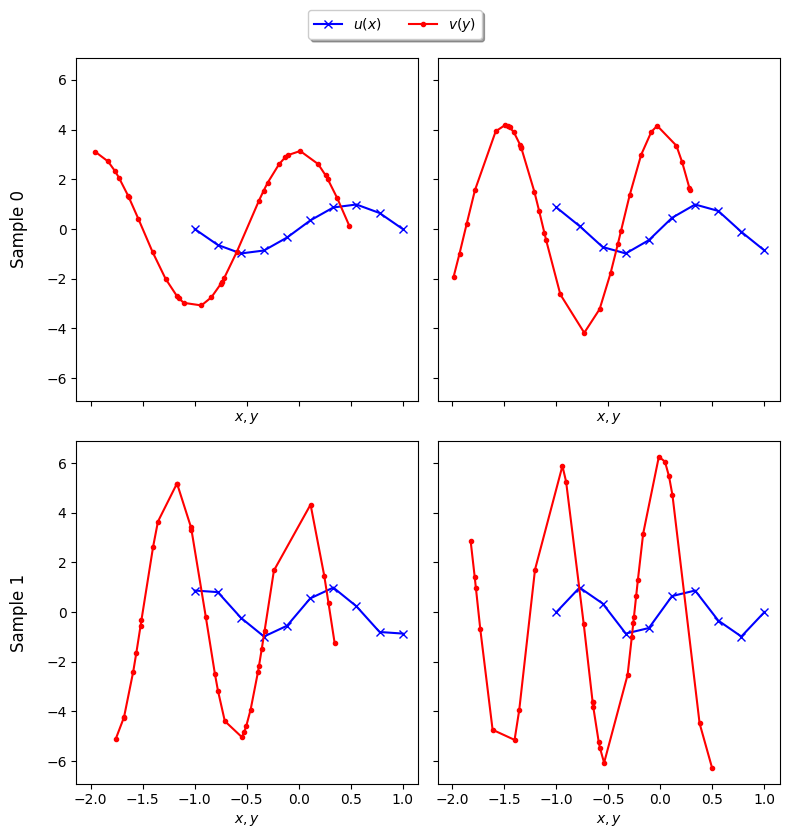

In [130]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)

for i, (x, u, y, v) in enumerate(dset):
    row, col = i // 2, i % 2
    axs[row, col].plot(x, u, 'bx-', label="$u(x)$")
    idx = torch.argsort(y.squeeze())
    y_plot, v_plot = y[idx], v[idx]
    axs[row, col].plot(y_plot, v_plot, 'r.-', label=r"$v(y)$")
    axs[row, col].set_xlabel("$x, y$")
lines_labels = [ax.get_legend_handles_labels() for ax in axs.flatten()]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
by_label = dict(zip(labels, lines))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', bbox_to_anchor=(0.5, 1.05),
           ncol=2, fancybox=True, shadow=True)
rows = [f"Sample {i}" for i in range(2)]
for ax, row in zip(axs[:, 0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
fig.tight_layout()

Or in a 2D domain with the Laplace operator
$$
\Delta:u\mapsto \sum_{i=1}^2 \frac{\partial^2 u}{\partial x_i^2},
$$
for the parameterized 2D function
$$
u_a: x=[x_1, x_2]^\top \mapsto \sin(ax_1+bx_2)+\sin(cx_1+dx_2), \quad a, b, c, d\in \mathbb{R},\quad x \in \mathbb{R}^2
$$
and its solution
$$
v_a: x=[x_1, x_2]^\top \mapsto -(a^2+b^2)\sin(ax_1+bx_2) - (c^2+d^2)\sin(cx_1+dx_2), \quad a, b, c, d\in \mathbb{R},\quad x \in \mathbb{R}^2.
$$

In [131]:
func = lambda a: lambda xi: torch.sin(a[0] * xi[:, 0] + a[1] * xi[:, 1])
u = FunctionSet(lambda a: lambda xi: (func(a[:2])(xi) + func(a[2:])(xi)).unsqueeze(1))
v = FunctionSet(lambda a: lambda xi: ((-a[0] ** 2 - a[1] ** 2) * func(a[:2])(xi) + (-a[2] ** 2 - a[3] ** 2) * func(a[2:])(xi)).unsqueeze(1))

x_sampler = RegularGridSampler(torch.Tensor([-1., -1.]), torch.Tensor([1., 1.]))
y_sampler = RegularGridSampler(torch.Tensor([-1., -1.]), torch.Tensor([1., 1.]))
parameter_sampler = UniformBoxSampler(torch.Tensor([2 * torch.pi, 2 * torch.pi, torch.pi, -2 * torch.pi]), torch.Tensor([4 * torch.pi, 4 * torch.pi, 2 * torch.pi, -torch.pi]))

dset_laplace = FunctionOperatorDataset(
    input_function_set=u,
    x_sampler=x_sampler,
    n_sensors=2500,
    solution_function_set=v,
    y_sampler=y_sampler,
    n_evaluations=2500,
    p_sampler=parameter_sampler,
    n_observations=4,
)

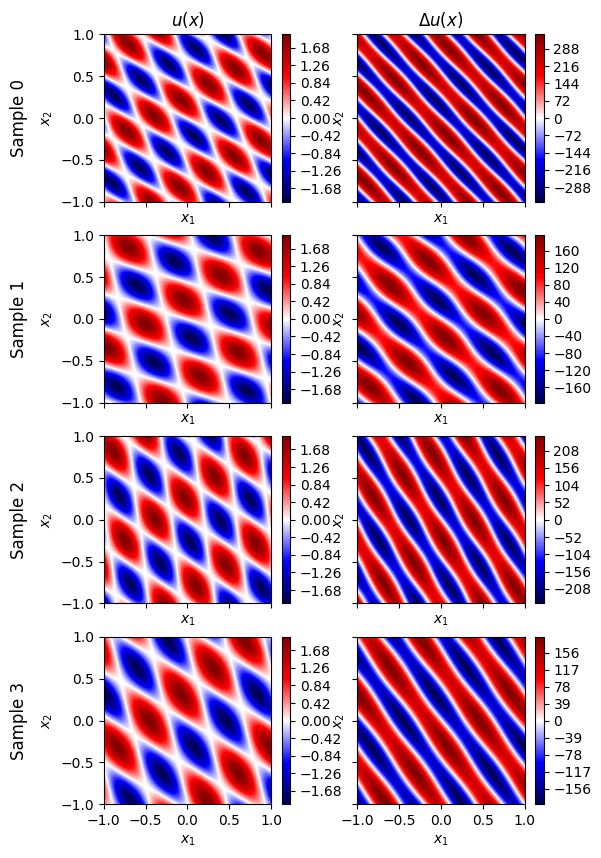

In [132]:
fig, axs = plt.subplots(nrows=4, ncols=2, sharex=True, sharey=True, figsize=(6, 10))

v_min = min(torch.min(dset_laplace.u), torch.min(dset_laplace.v))
v_max = max(torch.max(dset_laplace.u), torch.max(dset_laplace.v))
for i, (x, u, y, v) in enumerate(dset_laplace):
    u_plot = u.reshape(50, 50)
    v_plot = v.reshape(50, 50)
    v_abs_max = torch.max(torch.abs(u))
    im1 = axs[i, 0].contourf(u_plot, levels=256, extent=[-1, 1, -1, 1], cmap='seismic', vmax=v_abs_max, vmin=-v_abs_max)
    fig.colorbar(im1, ax=axs[i, 0])
    v_abs_max = torch.max(torch.abs(v))
    im2 = axs[i, 1].contourf(v_plot, levels=256, extent=[-1, 1, -1, 1], cmap='seismic', vmax=v_abs_max, vmin=-v_abs_max)
    fig.colorbar(im2, ax=axs[i, 1])
    axs[i, 0].set_aspect('equal')
    axs[i, 1].set_aspect('equal')
    axs[i, 0].set_xlabel('$x_1$')
    axs[i, 0].set_ylabel('$x_2$')
    axs[i, 1].set_xlabel('$x_1$')
    axs[i, 1].set_ylabel('$x_2$')

cols = ["$u(x)$", "$\Delta u(x)$"]
for ax, col in zip(axs[0], cols):
    ax.set_title(col)
rows = [f"Sample {i}" for i in range(4)]
for ax, row in zip(axs[:, 0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
